# Rotated Object Detection

In this tutorial, you will learn:
- the basic structure of Oriented R-CNN.
- to perform inference with a MMRotate detector.
- to perform inference on huge image.

Let's start!


## Install MMRotate

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!pip install mmdet

# Install mmrotate
!rm -rf mmrotate
!git clone https://github.com/open-mmlab/mmrotate.git
%cd mmrotate
!pip install -e .

# switch branch
!git checkout dev
!git branch -a

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
Cloning into 'mmrotate'...
remote: Enumerating objects: 652, done.
remote: Counting objects: 100% (652/652), done.
remote: Compressing objects: 100% (446/446), done.
remote: Total 652 (delta 287), reused 517 (delta 192), pack-reused 0
Receiving objects: 100% (652/652), 5.02 MiB | 1.12 MiB/s, done.
Resolving deltas: 100% (287/287), done.
/content/mmrotate
Obtaining file:///content/mmrotate
  Running setup.py develop for mmrotate
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
* dev
  main
  remotes/origin/HEAD -> origin/main
  remotes/origin/dev
  remotes/origin/main


In [3]:
from mmcv import collect_env
collect_env()

{'CUDA available': True,
 'CUDA_HOME': '/usr/local/cuda',
 'GCC': 'gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'GPU 0': 'Tesla K80',
 'MMCV': '1.4.6',
 'MMCV CUDA Compiler': '11.1',
 'MMCV Compiler': 'GCC 7.3',
 'NVCC': 'Build cuda_11.1.TC455_06.29190527_0',
 'OpenCV': '4.1.2',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86\n  - CuDNN

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
0.1.0
2.22.0
11.1
GCC 7.3


## Perform Inference with An MMRotate detector



### A two-stage detector

In this tutorial, we use Oriented R-CNN, a simple two-stage detector as an example.

The high-level architecture of Oriented R-CNN is shown in the following picture. More details can be found in the [paper](https://openaccess.thecvf.com/content/ICCV2021/papers/Xie_Oriented_R-CNN_for_Object_Detection_ICCV_2021_paper.pdf).

![oriented rcnn](https://raw.githubusercontent.com/zytx121/image-host/main/imgs/oriented_rcnn.png)


Briefly, it uses a convolutional neural network (CNN) as backbone to extract features from an image. Then, it uses a region proposal network (RPN) to predict proposals, i.e., potential objects. After that, it uses `RoIAlignRotated` to crop rotated features for the region of interests (RoI), and uses a RoI Head to perform classification and bounding box prediction.



In [5]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmrotate/v0.1.0/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth \
      -O checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth

--2022-03-03 14:56:31--  https://download.openmmlab.com/mmrotate/v0.1.0/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165749436 (158M) [application/octet-stream]
Saving to: ‘checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth’

checkpoints/oriente 100%[===================>] 158.07M  11.1MB/s    in 15s     

2022-03-03 14:56:46 (10.7 MB/s) - ‘checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth’ saved [165749436/165749436]



In [6]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth


OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

From the printed model, we will find that the model does consist of the components that we described earlier. It uses ResNet as its CNN backbone, and has a RPN head and RoI Head. In addition, the model has a neural network module, named neck, directly after the CNN backbone. It is a [feature pyramid network (FPN)](https://arxiv.org/abs/1612.03144) for enhancing the multi-scale features.


### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

In [8]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


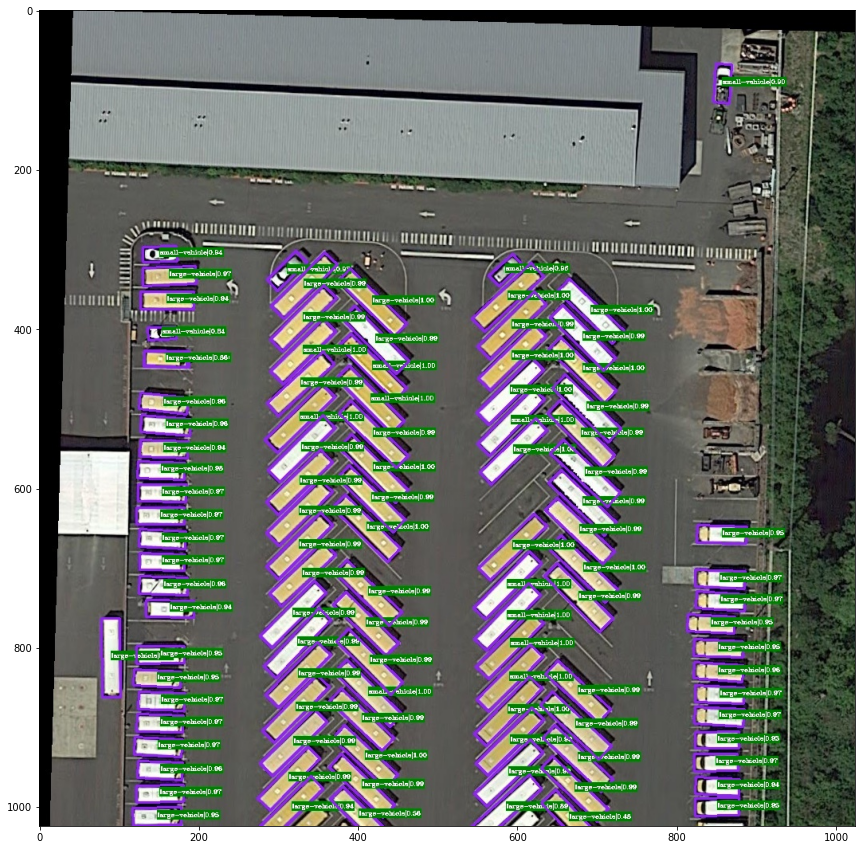

In [11]:
# Let's plot the result
import mmcv
import matplotlib.pyplot as plt

model.show_result(img, result, score_thr=0.3, out_file='./det.jpeg')
img = mmcv.imread('./det.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

### Inference on huge image
Since small image can be successfully detected, what about huge images in remote sensing? We use the high-level API `inference_detector_by_patches` implemented in the MMRotate. This API is created to ease the inference process for huge image. The details of the codes can be found [here](https://github.com/open-mmlab/mmrotate/blob/dev/mmrotate/apis/inference.py).

In [13]:
# Use the detector to do inference
from mmrotate.apis import inference_detector_by_patches
img = 'demo/dota_demo.jpg'
result = inference_detector_by_patches(model, img, [1024], [824], [1.0], 0.1)

/usr/local/lib/python3.7/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


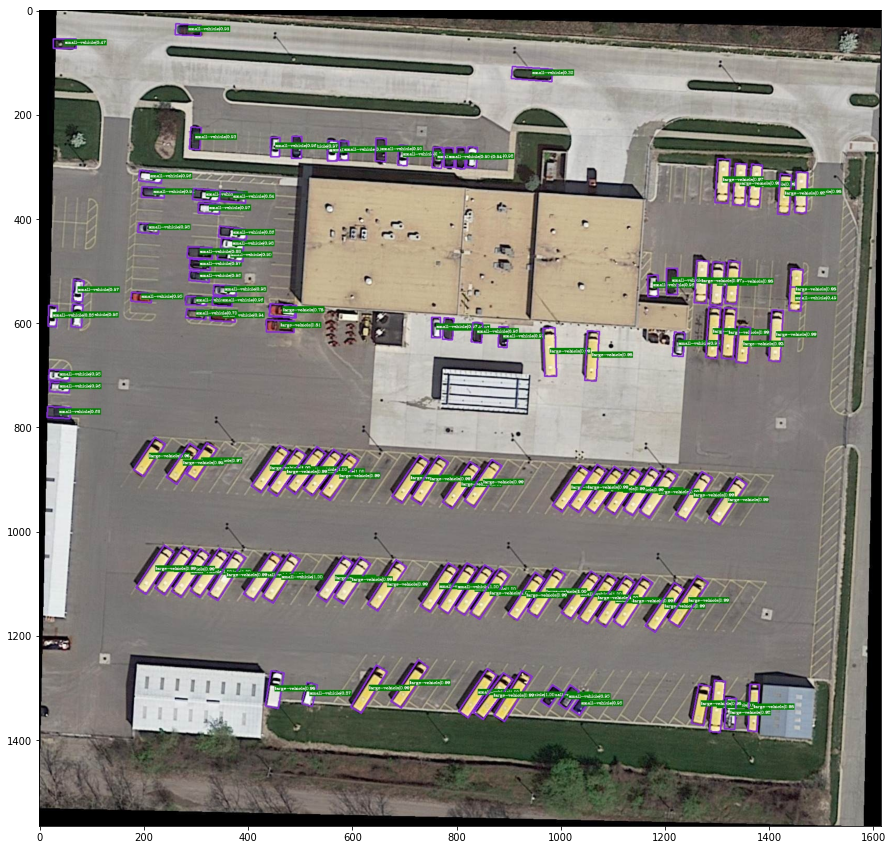

In [14]:
# Let's plot the result
import mmcv
import matplotlib.pyplot as plt

model.show_result(img, result, score_thr=0.3, out_file='./det_huge.jpeg')
img = mmcv.imread('./det_huge.jpeg')
plt.figure(figsize=(20, 15))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

## What to Do Next?

So far, we have learnt how to test a two-stage detector using MMRotate. To further explore MMRotate, you could do several other things as shown below:

- Try single-stage detectors, e.g., [Rotated RetinaNet](https://github.com/open-mmlab/mmrotate/tree/dev/configs/rotated_retinanet) and [GWD](https://github.com/open-mmlab/mmrotate/tree/dev/configs/gwd) in [MMRotate model zoo](https://github.com/open-mmlab/mmrotate/blob/dev/docs/en/model_zoo.md). Single-stage detectors are more commonly used than two-stage detectors in industry.
- Try anchor-free detectors, e.g., [Rotated RepPoints](https://github.com/open-mmlab/mmrotate/tree/dev/configs/rotated_reppoints) and [CFA](https://github.com/open-mmlab/mmrotate/tree/dev/configs/cfa) in [MMRotate model zoo](https://github.com/open-mmlab/mmrotate/blob/dev/docs/en/model_zoo.md). Anchor-free detector is a new trend in the object detection community.
